In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from matplotlib.font_manager import FontProperties 
import matplotlib.dates as mdates
fontset02 = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc", size=12) #微軟標準


%autosave 120

Autosaving every 120 seconds


In [2]:
path_clean = r'/Users/liang/Documents/NCKU_DS/資料科學/數位沙盒/clean_data'
data = pd.read_csv(path_clean + r'/1_data.csv')

path_fig = r'/Users/liang/Documents/NCKU_DS/資料科學/數位沙盒/Figures/EDA'

In [3]:
data.shape

(67365, 37)

In [826]:
# 0. mdate 交易日平均房價
# 1. 不同區域的平均房價
# 2. 不同tran_tp的平均房價 與 tran_tp個別的數量
# 3. 不同tsign 的平均房價 tsign個別的數量
# 4. road_fg與平均房價 （論文好像都沒放）

# 6. land_area 與房價
# 7. zoning與房價
# 8. tran_up_ll 當ordinal?
# 9. bstate與房價
# 10. mainuse
# 11. matl
# 12. room_age
# 13. build_area與房價
# 14. room	hall	health
# 15. mgt_com 管理組織(Y/N)

# y: tot_prc, unit_prc 

# land build畫散步圖！
# 特殊關西交易

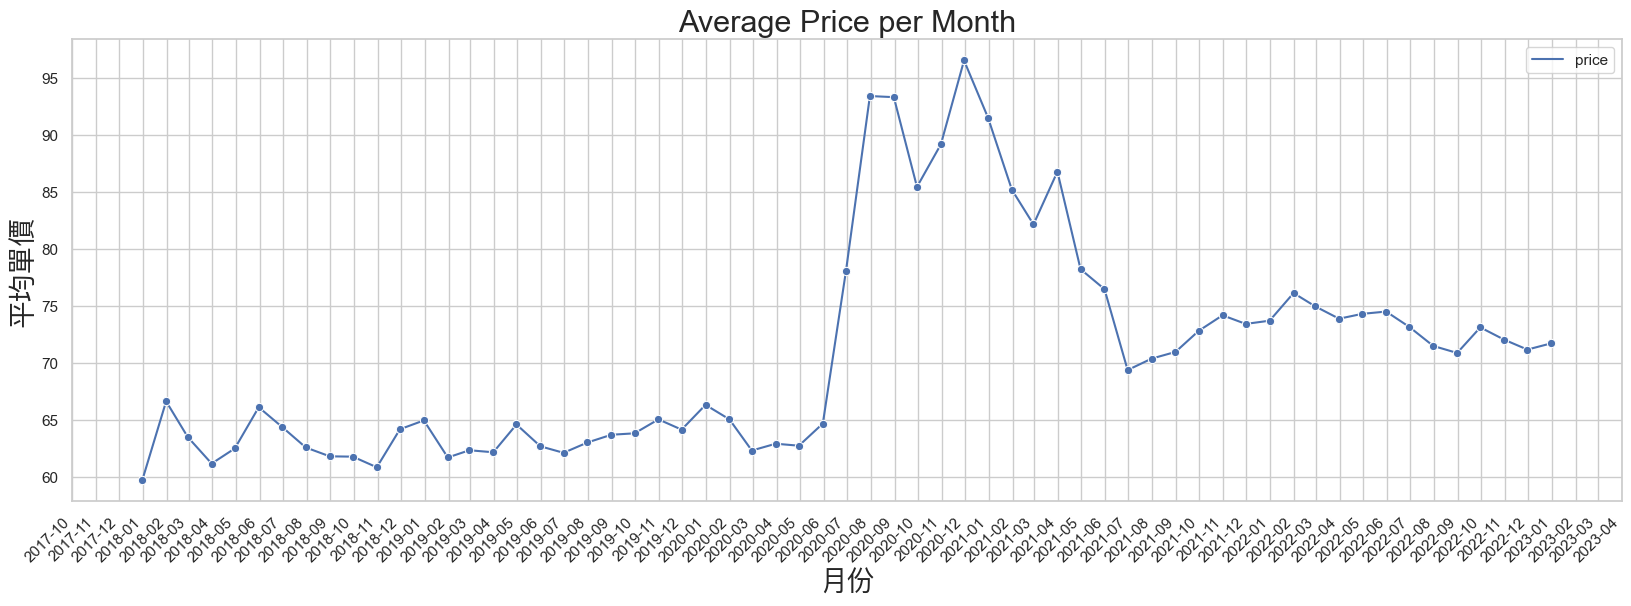

In [12]:
# 0. mdate 交易日平均房價
dates = data['mdate']
dates = pd.to_datetime(dates)
date_price = pd.DataFrame({'dates': dates, 'price': data['unit_prc']})
date_price.set_index('dates', inplace=True)
monthly_data = date_price.resample('M').mean()

plt.figure(figsize=(20, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data=monthly_data, marker='o', ci='sd')
# sns.lineplot(data=monthly_data, marker='o', ci=95)# 

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45, ha='right')

plt.title('Average Price per Month', size=22)
plt.xlabel('月份', size=20, fontproperties=fontset02)
plt.ylabel('平均單價', size=20, fontproperties=fontset02)

plt.savefig(path_fig + r'/mdate.png', dpi=300, bbox_inches='tight')

plt.show()

In [72]:
data.groupby('district_id')['unit_prc'].mean()

district_id
中山區    74.352180
中正區    83.556620
信義區    79.467004
內湖區    58.668061
北投區    54.629074
南港區    70.373885
士林區    62.619124
大同區    64.565110
大安區    92.936757
文山區    53.216523
松山區    80.320731
萬華區    54.064499
Name: unit_prc, dtype: float64

In [35]:
data.groupby(['district_id']).agg(
    平均單價=('unit_prc', np.mean),
    標準差 =('unit_prc', np.std)).reset_index()


,district_id,平均單價,標準差
0,中山區,74.352180,29.663375
1,中正區,83.556620,36.454183
2,信義區,79.467004,30.918791
3,內湖區,58.668061,18.885631
4,北投區,54.629074,22.543690
5,南港區,70.373885,25.374672
6,士林區,62.619124,79.738421
7,大同區,64.565110,26.794422
8,大安區,92.936757,32.904983
9,文山區,53.216523,17.604629


In [82]:
# data[data["district_id"]=='士林區']['unit_prc'].describe()

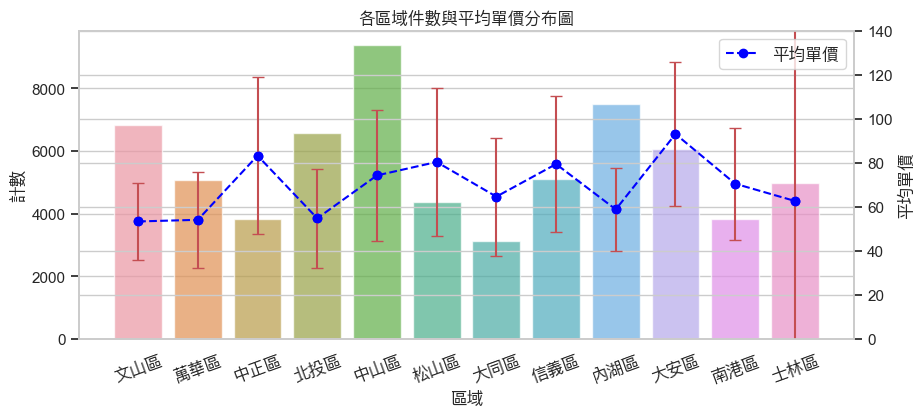

In [118]:
# district_id與房價與平均房價 

sns.set_palette('pastel') 
plt.figure(figsize=(10, 4))
ax1 = sns.countplot(x = data["district_id"], alpha=0.7)
ax1.set_xlabel('區域', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)
# 加數值
# for p in ax1.patches:
#     ax1.annotate(f'{int(p.get_height())}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', 
#                 xytext=(0, 10), 
#                 textcoords='offset points', 
#                 fontproperties=fontset02)

    
# avg_price_per_area = data.groupby('district_id')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['district_id']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()

order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['district_id'] = pd.Categorical(
    avg_price_per_area['district_id'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('district_id')

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
ax2.set_ylim(0, 140) 


ax2.plot(avg_price_per_area['district_id'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['district_id'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')
#              mfc=None, mec=None, label='ci')

# 這是一個標準差 要畫95%ci嗎？ 還是label就寫一個標準差

ax2.legend(loc='upper right', prop=fontset02)

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)
ax1.tick_params(axis='x', labelrotation=20)

plt.title('各區域件數與平均單價分布圖', fontproperties=fontset02)
plt.savefig(path_fig + r'/district_id.png', dpi=300, bbox_inches='tight')
plt.show()


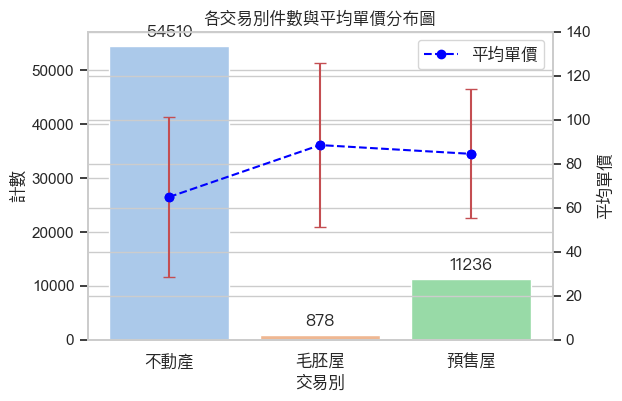

In [119]:
# tran_tp與房價與平均房價 

sns.set_palette('pastel') 
plt.figure(figsize=(6, 4))
ax1 = sns.countplot(x = data["tran_tp"])
ax1.set_xlabel('交易別', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)
# 加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

    
# avg_price_per_area = data.groupby('tran_tp')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['tran_tp']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()

order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['tran_tp'] = pd.Categorical(
    avg_price_per_area['tran_tp'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('tran_tp')

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
ax2.set_ylim(0, 140) 
ax2.plot(avg_price_per_area['tran_tp'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')

ax2.errorbar(avg_price_per_area['tran_tp'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

ax2.legend(loc='upper right', prop=fontset02)

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)

plt.title('各交易別件數與平均單價分布圖', fontproperties=fontset02)
plt.savefig(path_fig + r'/tran_tp.png', dpi=300, bbox_inches='tight')
plt.show()

# 預售屋類似房地產的期貨，賣的是未來價格，所以成交行情會比成屋預售屋類似房地產的期貨，賣的是未來價格，所以成交行情會比成屋３高

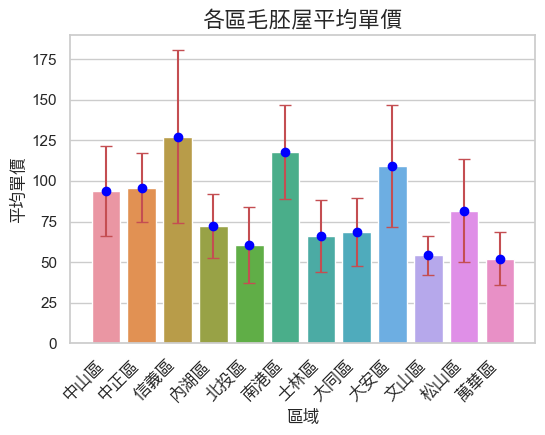

In [86]:
data_mao = data[data['tran_tp']=='毛胚屋']

avg_price_per_area = data_mao.groupby(['district_id']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()

#avg_price_per_area = data_mao.groupby('district_id')['unit_prc'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.set_theme(style="whitegrid")
sns.barplot(data=avg_price_per_area, x='district_id', y='平均單價')
plt.errorbar(avg_price_per_area['district_id'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

plt.xlabel('區域', size=12, fontproperties=fontset02)
plt.ylabel('平均單價', size=12, fontproperties=fontset02)
plt.title('各區毛胚屋平均單價', fontproperties=fontset02, size=16)
plt.xticks(rotation=45, ha='right', fontproperties=fontset02)

plt.savefig(path_fig + r'/mao_dist.png', dpi=300, bbox_inches='tight')
plt.show()
# 信義區、南港區、大安區 
# 毛胚屋多屬於大坪數的豪宅

In [831]:
#data_mao.loc[:, ['district_id', 'room', 'hall', 'health', 'unit_prc', 'rmk']]

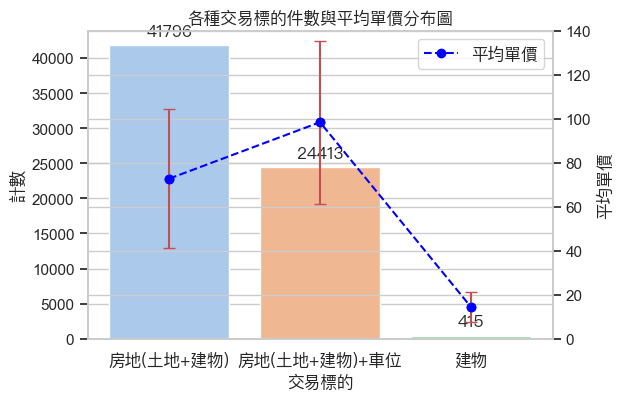

In [120]:
# tran_tp與房價與平均房價 
# 房屋單價 = (總價-車位價格)/ (總坪數-車位坪數)

sns.set_palette('pastel') 
plt.figure(figsize=(6, 4))
ax1 = sns.countplot(x = data["tsign"])
ax1.set_xlabel('交易標的', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)
# 加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

    
# avg_price_per_area = data.groupby('tsign')['unit_prc'].mean().reset_index()
avg_price_per_area = data_mao.groupby(['tsign']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()
order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['tsign'] = pd.Categorical(
    avg_price_per_area['tsign'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('tsign')

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
ax2.set_ylim(0, 140) 
ax2.plot(avg_price_per_area['tsign'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['tsign'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

ax2.legend(loc='upper right', prop=fontset02)

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)


plt.title('各種交易標的件數與平均單價分布圖', fontproperties=fontset02)
plt.savefig(path_fig + r'/tsign.png', dpi=300, bbox_inches='tight')
plt.show()

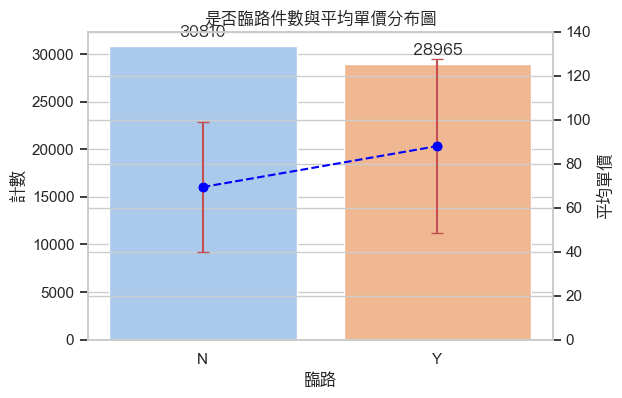

In [121]:
# 4. road_fg與平均房價 （論文沒放）

sns.set_palette('pastel') 
plt.figure(figsize=(6, 4))
ax1 = sns.countplot(x = data["road_fg"])
ax1.set_xlabel('臨路', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)
# 加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

avg_price_per_area = data_mao.groupby(['road_fg']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()    
# avg_price_per_area = data.groupby('road_fg')['unit_prc'].mean().reset_index()

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
ax2.set_ylim(0, 140) 
ax2.plot(avg_price_per_area['road_fg'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['road_fg'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

#ax2.legend(prop=fontset02)


plt.title('是否臨路件數與平均單價分布圖', fontproperties=fontset02)
plt.savefig(path_fig + r'/road_fg.png', dpi=300, bbox_inches='tight')
plt.show()

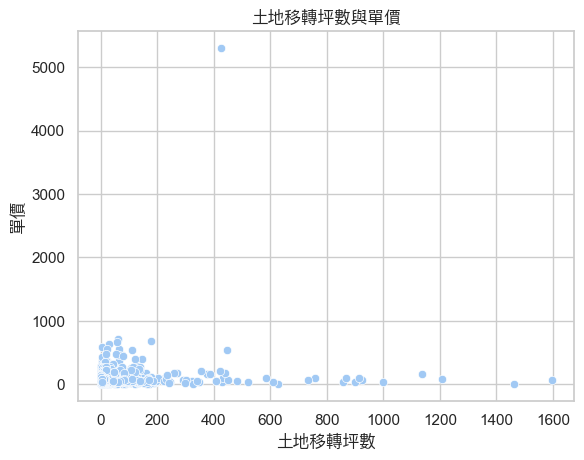

In [834]:
# 6. land_area 與房價
sns.scatterplot(x='land_area', y='unit_prc', data=data)
plt.title('土地移轉坪數與單價', size=14, fontproperties=fontset02)
plt.xlabel('土地移轉坪數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/land_area.png', dpi=300, bbox_inches='tight')
plt.show()

In [835]:
data[data['unit_prc'] >= 5000]

,ID,mdate,district_id,tran_tp,tsign,location,road_fg,coord_x,coord_y,land,...,health,compart,mgt_com,berth_tp,berth_area,tot_prc,unit_prc,berth_prc,rmk,ann_date
1804,2169,2018-01-05,士林區,不動產,房地(土地+建物),臺北市士林區芝玉路一段220巷1~30號,N,25.109213,121.534833,5,...,5,Y,N,NaN,0.0,59679.0,5303.4,0.0,親友、員工或其他特殊關係間之交易。含增建或未登記建物。,2018-03-31


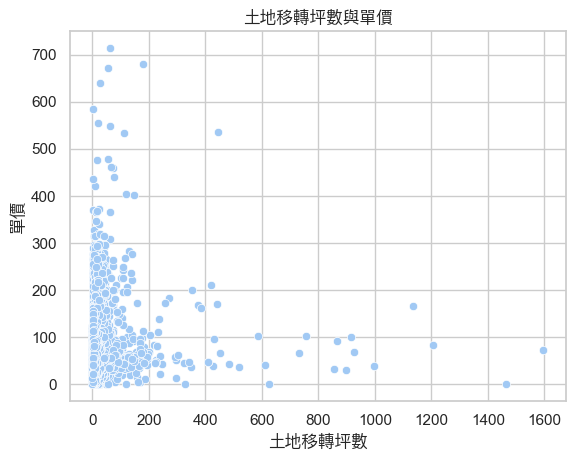

In [836]:
# 6. land_area 與房價
filtered_data = data[data['unit_prc'] <= 5000]
sns.scatterplot(x='land_area', y='unit_prc', data=filtered_data)
plt.title('土地移轉坪數與單價', size=14, fontproperties=fontset02)
plt.xlabel('土地移轉坪數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)

plt.savefig(path_fig + r'/land_area2.png', dpi=300, bbox_inches='tight')
plt.show()

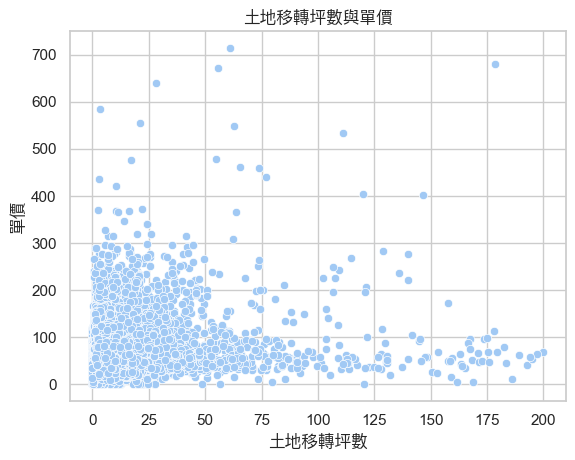

In [837]:
# 6. land_area 與房價
filtered_data = filtered_data[filtered_data['land_area'] <= 200]
sns.scatterplot(x='land_area', y='unit_prc', data=filtered_data)
plt.title('土地移轉坪數與單價', size=14, fontproperties=fontset02)
plt.xlabel('土地移轉坪數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/land_area3.png', dpi=300, bbox_inches='tight')
plt.show()

In [838]:
data[data['unit_prc']>5000]#['rmk'] # 屋齡84年 11坪透天厝 磚造 特殊關係 土地移轉坪數426.31超大

,ID,mdate,district_id,tran_tp,tsign,location,road_fg,coord_x,coord_y,land,...,health,compart,mgt_com,berth_tp,berth_area,tot_prc,unit_prc,berth_prc,rmk,ann_date
1804,2169,2018-01-05,士林區,不動產,房地(土地+建物),臺北市士林區芝玉路一段220巷1~30號,N,25.109213,121.534833,5,...,5,Y,N,NaN,0.0,59679.0,5303.4,0.0,親友、員工或其他特殊關係間之交易。含增建或未登記建物。,2018-03-31


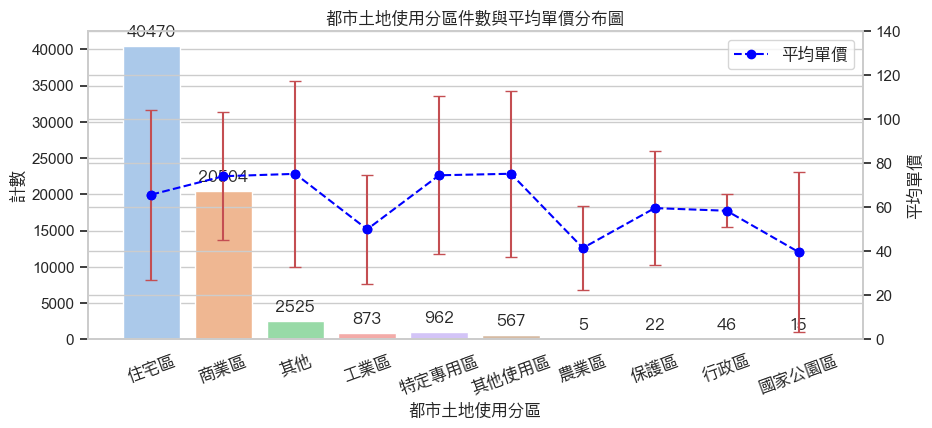

In [122]:
# zoning與房價與平均房價 

sns.set_palette('pastel') 
plt.figure(figsize=(10, 4))
ax1 = sns.countplot(x = data["zoning"])
ax1.set_xlabel('都市土地使用分區', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)
# 加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

    
# avg_price_per_area = data.groupby('zoning')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['zoning']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()    
order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['zoning'] = pd.Categorical(
    avg_price_per_area['zoning'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('zoning')

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
ax2.set_ylim(0, 140) 
ax2.plot(avg_price_per_area['zoning'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['zoning'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)
ax1.tick_params(axis='x', labelrotation=20)
ax2.legend(prop=fontset02)

plt.title('都市土地使用分區件數與平均單價分布圖', fontproperties=fontset02)

plt.savefig(path_fig + r'/zoning.png', dpi=300, bbox_inches='tight')
plt.show()

In [105]:
# 暫時拋棄有兩層樓以上的資料
data = data[data['tran_up_ll'] != 999]

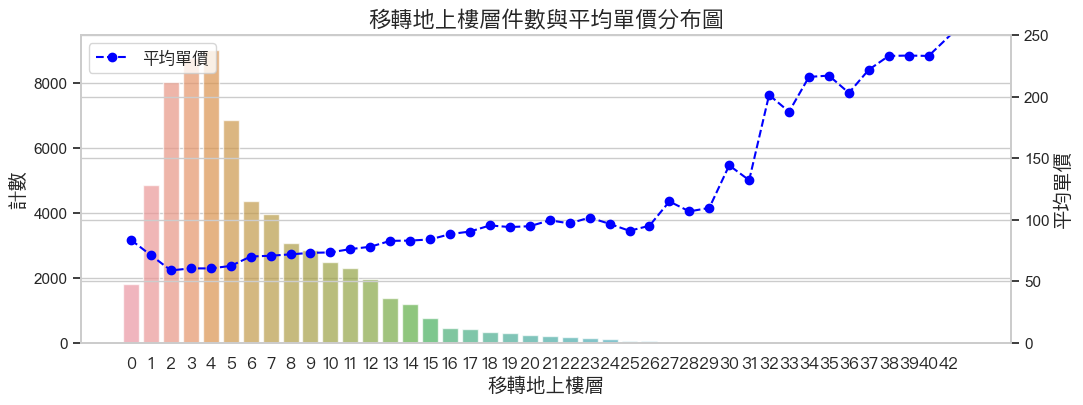

In [106]:
# tran_up_ll與平均房價

sns.set_palette('pastel') 
plt.figure(figsize=(12, 4))
ax1 = sns.countplot(x = data["tran_up_ll"], alpha=0.7)
ax1.set_xlabel('移轉地上樓層', fontproperties=fontset02, size=14)
ax1.set_ylabel('計數', fontproperties=fontset02, size=14)
# 加數值
# for p in ax1.patches:
#     ax1.annotate(f'{int(p.get_height())}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', 
#                 xytext=(0, 10), 
#                 textcoords='offset points', 
#                 fontproperties=fontset02)

    
avg_price_per_area = data.groupby('tran_up_ll')['unit_prc'].mean().reset_index()

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=14, fontproperties=fontset02)
ax2.set_ylim(0, 250) 
ax2.plot(avg_price_per_area['tran_up_ll'], avg_price_per_area['unit_prc'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)
#ax1.tick_params(axis='x', labelrotation=20)
ax2.legend(prop=fontset02)

plt.title('移轉地上樓層件數與平均單價分布圖', fontproperties=fontset02, size=16)
plt.savefig(path_fig + r'/tran_up_ll.png', dpi=300, bbox_inches='tight')

plt.show()


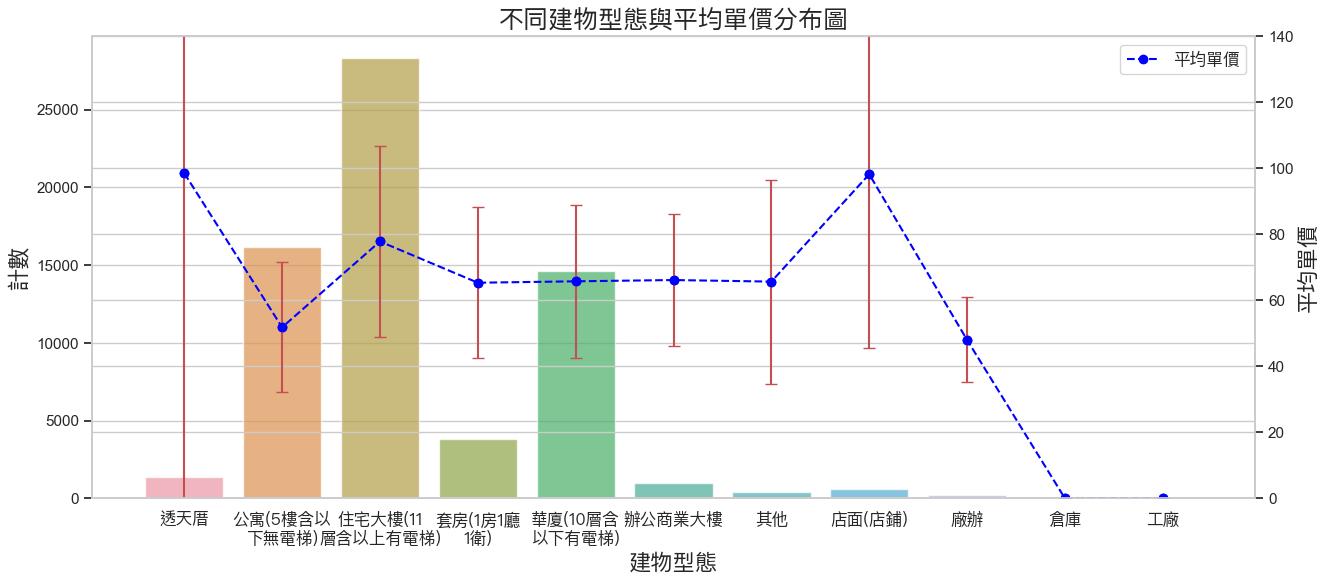

In [123]:
# 9. bstate與房價

sns.set_palette('pastel') 
plt.figure(figsize=(15,6))
ax1 = sns.countplot(x = data["bstate"], alpha=0.7)
ax1.set_xlabel('建物型態', size=16, fontproperties=fontset02)
ax1.set_ylabel('計數', size=16, fontproperties=fontset02)

# avg_price_per_area = data.groupby('bstate')['unit_prc'].mean().reset_index()

avg_price_per_area = data.groupby(['bstate']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()  

order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['bstate'] = pd.Categorical(
    avg_price_per_area['bstate'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('bstate')

#加數值
# for p in ax1.patches:
#     ax1.annotate(f'{int(p.get_height())}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', 
#                 xytext=(0, 10), 
#                 textcoords='offset points', 
#                 fontproperties=fontset02)

    

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=16, fontproperties=fontset02)
ax2.set_ylim(0, 140) 
ax2.plot(avg_price_per_area['bstate'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['bstate'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)
    


labels = [text.get_text() for text in ax1.get_xticklabels()]
new_labels= [label if len(label) < 7 else label[:7] + '\n' + label[7:] for label in labels]
ax1.set_xticklabels(new_labels)


ax2.legend(prop=fontset02)

plt.title('不同建物型態與平均單價分布圖', fontproperties=fontset02, size=18)
plt.savefig(path_fig + r'/bstatel.png', dpi=300, bbox_inches='tight')

plt.show()


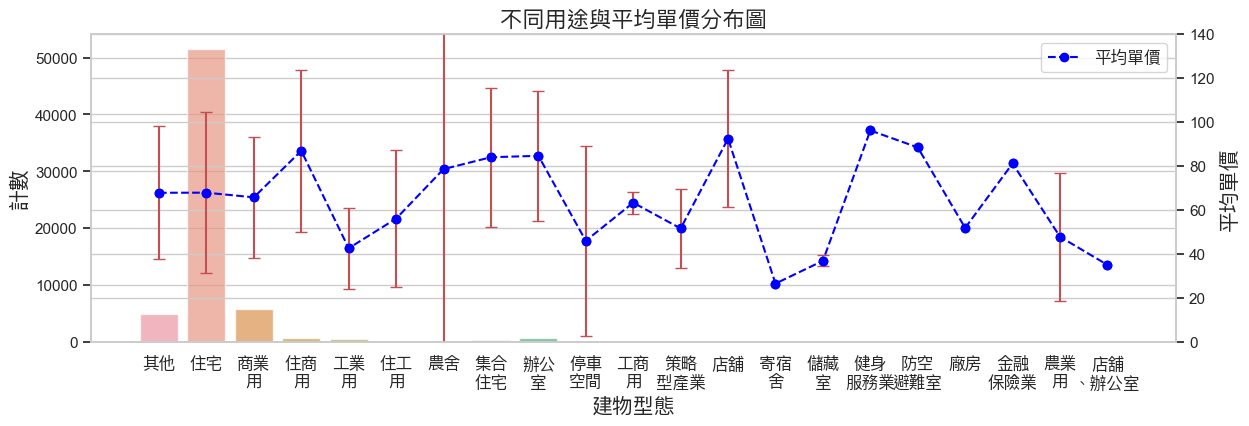

In [124]:
# 10. mainuse與房價

sns.set_palette('pastel') 
plt.figure(figsize=(14, 4))
ax1 = sns.countplot(x = data["mainuse"], alpha=0.7)
ax1.set_xlabel('建物型態', size=15, fontproperties=fontset02)
ax1.set_ylabel('計數', size=15, fontproperties=fontset02)

# avg_price_per_area = data.groupby('mainuse')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['mainuse']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()  


order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['mainuse'] = pd.Categorical(
    avg_price_per_area['mainuse'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('mainuse')

#加數值
# for p in ax1.patches:
#     ax1.annotate(f'{int(p.get_height())}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', 
#                 xytext=(0, 10), 
#                 textcoords='offset points', 
#                 fontproperties=fontset02)

    

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=15, fontproperties=fontset02)
ax2.set_ylim(0, 140) 
ax2.plot(avg_price_per_area['mainuse'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')

ax2.errorbar(avg_price_per_area['mainuse'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')


for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)


labels = [text.get_text() for text in ax1.get_xticklabels()]
new_labels= [label if len(label) < 2 else label[:2] + '\n' + label[2:] for label in labels]
ax1.set_xticklabels(new_labels)
ax2.legend(prop=fontset02)

plt.title('不同用途與平均單價分布圖', fontproperties=fontset02, size=16)
plt.savefig(path_fig + r'/mainus.png', dpi=300, bbox_inches='tight')

plt.show()


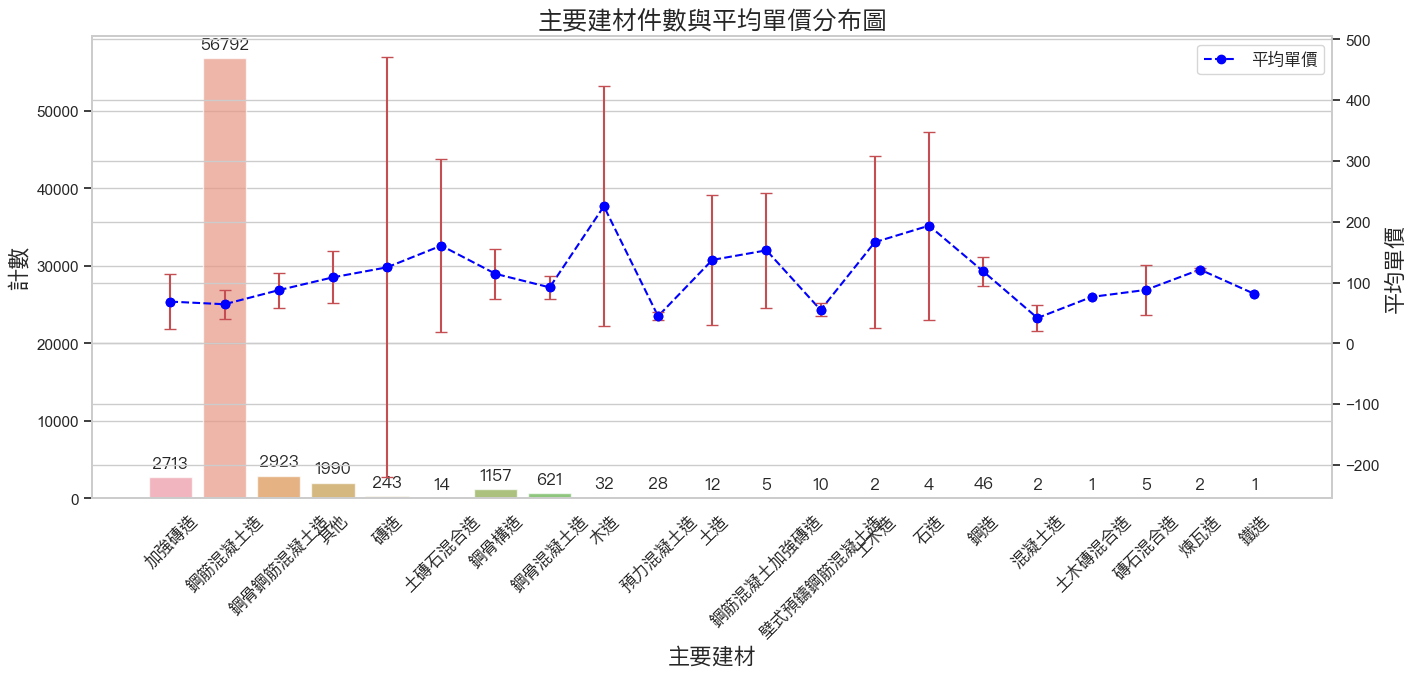

In [126]:
# 10. matl與房價

sns.set_palette('pastel') 
plt.figure(figsize=(16, 6))
ax1 = sns.countplot(x = data["matl"], alpha=0.7)
ax1.set_xlabel('主要建材', size=16, fontproperties=fontset02)
ax1.set_ylabel('計數', size=16, fontproperties=fontset02)

# avg_price_per_area = data.groupby('matl')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['matl']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()  

order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['matl'] = pd.Categorical(
    avg_price_per_area['matl'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('matl')

#加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

    

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=16, fontproperties=fontset02)
# ax2.set_ylim(0, 100) 
ax2.plot(avg_price_per_area['matl'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')

ax2.errorbar(avg_price_per_area['matl'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)
    

ax2.legend(prop=fontset02)
ax1.tick_params(axis='x', labelrotation=45)

plt.title('主要建材件數與平均單價分布圖', fontproperties=fontset02, size=18)
plt.savefig(path_fig + r'/matl.png', dpi=300, bbox_inches='tight')

plt.show()


In [896]:
u = filtered_data[filtered_data['unit_prc']>450]
u[u['room_age']>40]['district_id']

1815     士林區
28097    士林區
28726    中山區
37104    中山區
Name: district_id, dtype: object

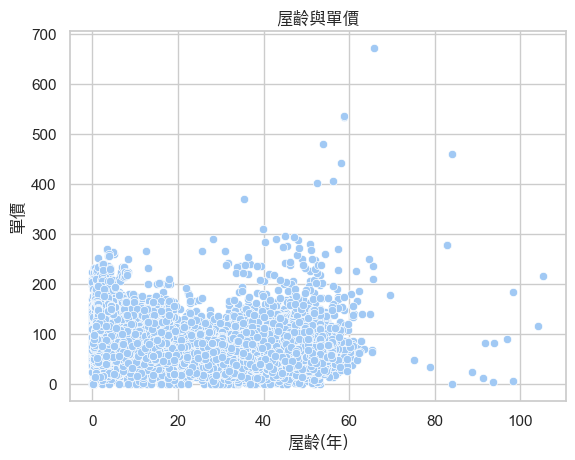

In [900]:
# 12. room_age
sns.scatterplot(x='room_age', y='unit_prc', data=filtered_data)
plt.title('屋齡與單價', size=14, fontproperties=fontset02)
plt.xlabel('屋齡(年)', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/room_age.png', dpi=300, bbox_inches='tight')

plt.show()

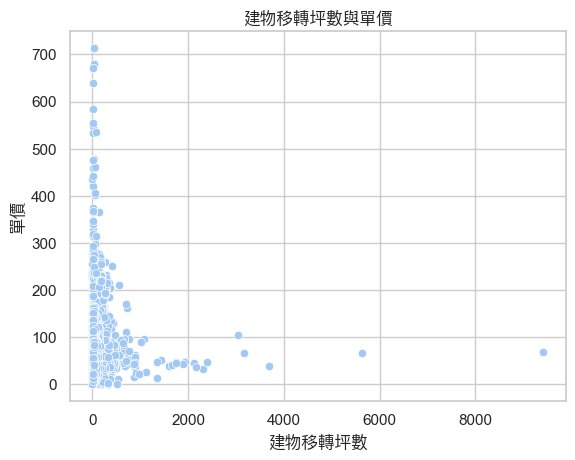

In [901]:
# 13. build_area與房價
sns.scatterplot(x='build_area', y='unit_prc', data=filtered_data)
plt.title('建物移轉坪數與單價', size=14, fontproperties=fontset02)
plt.xlabel('建物移轉坪數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/build_area.png', dpi=300, bbox_inches='tight')

plt.show()

In [903]:
a = filtered_data[filtered_data['build_area'] >= 3000]
a.to_csv(path_clean + r'/a.csv', sep=',', encoding='utf-8', index=False)

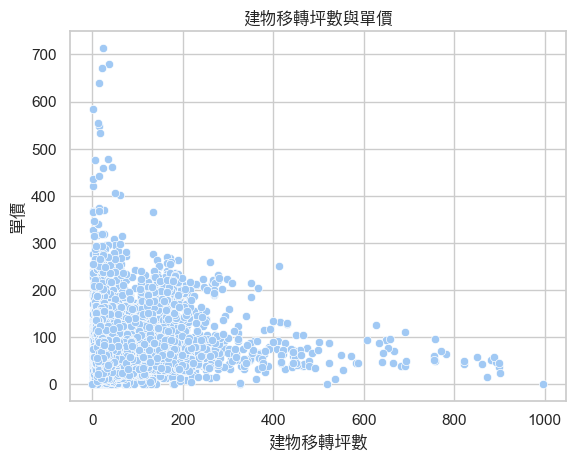

In [849]:
filtered_data2 = filtered_data[filtered_data['build_area'] <= 1000]
sns.scatterplot(x='build_area', y='unit_prc', data=filtered_data2)
plt.title('建物移轉坪數與單價', size=14, fontproperties=fontset02)
plt.xlabel('建物移轉坪數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/build_area2.png', dpi=300, bbox_inches='tight')

plt.show()

In [904]:
a = filtered_data[filtered_data['room'] >= 60]
a.to_csv(path_clean + r'/a.csv', sep=',', encoding='utf-8', index=False)

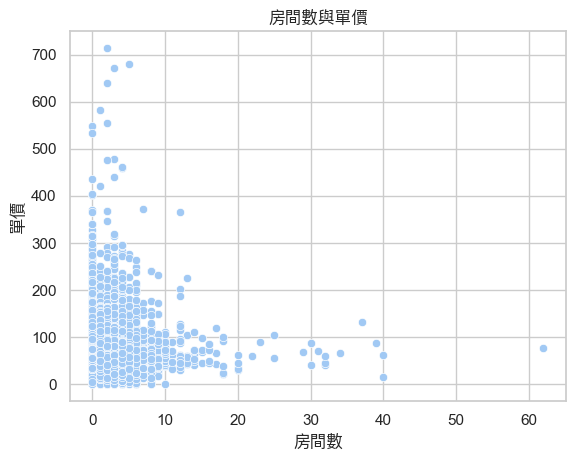

In [850]:
sns.scatterplot(x='room', y='unit_prc', data=filtered_data)
plt.title('房間數與單價', size=14, fontproperties=fontset02)
plt.xlabel('房間數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
#plt.xticks(range(18), label = [range(18)])
plt.savefig(path_fig + r'/room.png', dpi=300, bbox_inches='tight')

plt.show()

# 0房0廳0衛

In [851]:
filtered_data[filtered_data['room'] >= 40]

,ID,mdate,district_id,tran_tp,tsign,location,road_fg,coord_x,coord_y,land,...,health,compart,mgt_com,berth_tp,berth_area,tot_prc,unit_prc,berth_prc,rmk,ann_date
18780,22679,2019-05-13,大安區,不動產,房地(土地+建物)+車位,臺北市大安區忠孝東路四段271~300號,Y,25.041673,121.553981,10,...,0,Y,Y,坡道平面,150.57,49666.0,76.1,0.0,NaN,2019-10-11
41142,32046,2021-08-03,中山區,預售屋,房地(土地+建物),臺北市中山區新生北路三段５６巷１４號3樓,N,25.065217,121.526868,1,...,40,Y,N,NaN,0.00,49380.0,63.1,0.0,NaN,2021-12-13
42798,33893,2021-09-01,中正區,不動產,建物,臺北市中正區懷寧街５之１號,Y,25.046290,121.514313,0,...,0,Y,N,NaN,0.00,10.0,15.6,0.0,NaN,2021-10-21


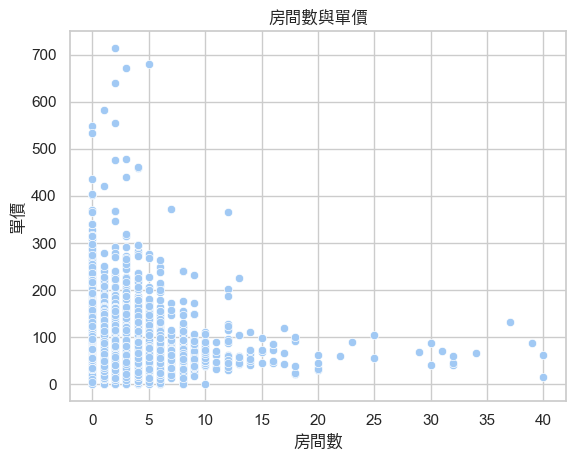

In [852]:
filtered_data3 = filtered_data[filtered_data['room'] <= 40]

sns.scatterplot(x='room', y='unit_prc', data=filtered_data3)
plt.title('房間數與單價', size=14, fontproperties=fontset02)
plt.xlabel('房間數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
#plt.xticks(range(18), label = [range(18)])
plt.savefig(path_fig + r'/room2.png', dpi=300, bbox_inches='tight')

plt.show()

# 0房0廳0衛

In [907]:
a = filtered_data[filtered_data['hall'] >= 20]
a.to_csv(path_clean + r'/a.csv', sep=',', encoding='utf-8', index=False)

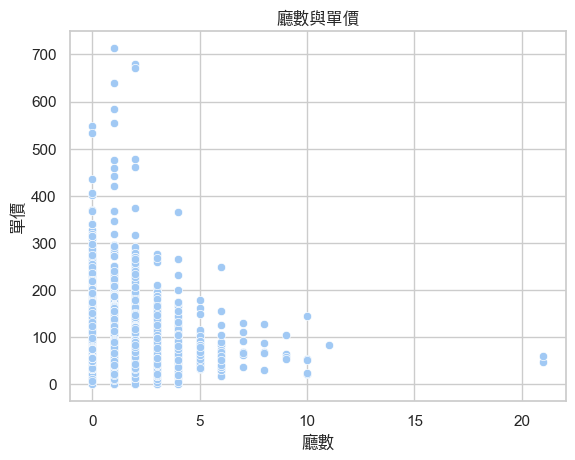

In [854]:
sns.scatterplot(x='hall', y='unit_prc', data=filtered_data)
plt.title('廳數與單價', size=14, fontproperties=fontset02)
plt.xlabel('廳數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/hall.png', dpi=300, bbox_inches='tight')

plt.show()

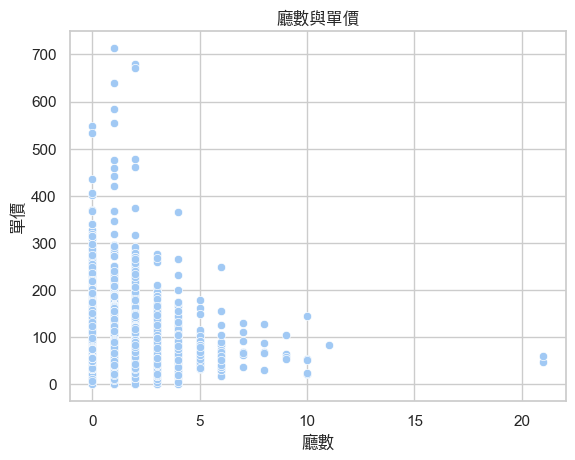

In [855]:
filtered_data4 = filtered_data[filtered_data['room'] <= 30]
sns.scatterplot(x='hall', y='unit_prc', data=filtered_data4)
plt.title('廳數與單價', size=14, fontproperties=fontset02)
plt.xlabel('廳數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/hall2.png', dpi=300, bbox_inches='tight')

plt.show()

In [916]:
a = filtered_data[filtered_data['health'] >= 20]
a.to_csv(path_clean + r'/a.csv', sep=',', encoding='utf-8', index=False)

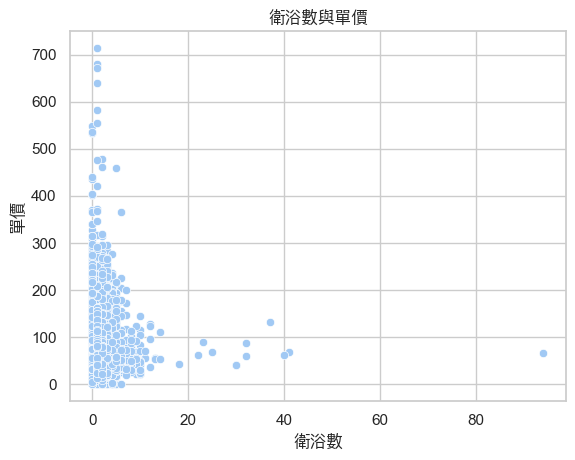

In [912]:
sns.scatterplot(x='health', y='unit_prc', data=filtered_data)
plt.title('衛浴數與單價', size=14, fontproperties=fontset02)
plt.xlabel('衛浴數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/health.png', dpi=300, bbox_inches='tight')

plt.show()

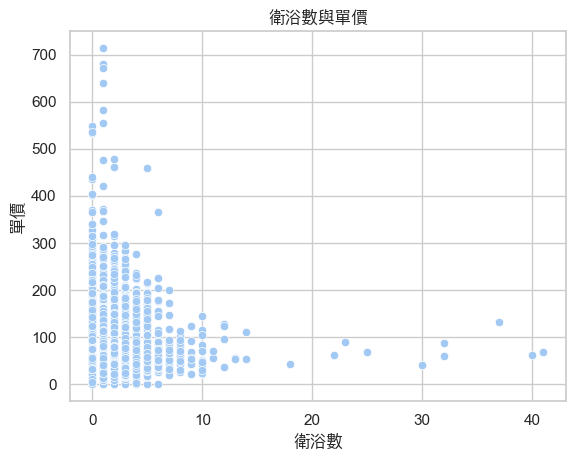

In [914]:
#filtered_data[filtered_data['berth'] >= 100]
filtered_data5 = filtered_data[filtered_data['health'] <= 45]
sns.scatterplot(x='health', y='unit_prc', data=filtered_data5)
plt.title('衛浴數與單價', size=14, fontproperties=fontset02)
plt.xlabel('衛浴數', size=12, fontproperties=fontset02)
plt.ylabel('單價', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/health2.png', dpi=300, bbox_inches='tight')

plt.show()

In [858]:
data[data['berth']>20]['bstate']# 辦公商業大樓或廠辦

1015          套房(1房1廳1衛)
1372              辦公商業大樓
3776                  廠辦
16470                 其他
17546                 廠辦
17929             辦公商業大樓
25516                 其他
38350    住宅大樓(11層含以上有電梯)
42320    住宅大樓(11層含以上有電梯)
49007      華廈(10層含以下有電梯)
49694    住宅大樓(11層含以上有電梯)
50628      華廈(10層含以下有電梯)
53244    住宅大樓(11層含以上有電梯)
62897      華廈(10層含以下有電梯)
Name: bstate, dtype: object

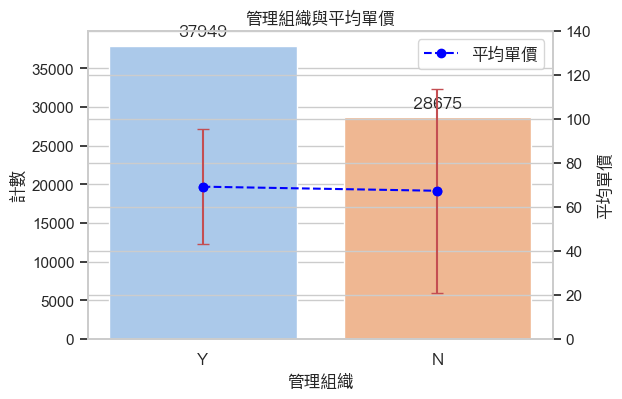

In [127]:
# 10.mgt_com與房價

sns.set_palette('pastel') 
plt.figure(figsize=(6, 4))
ax1 = sns.countplot(x = data["mgt_com"])
ax1.set_xlabel('管理組織', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)

# avg_price_per_area = data.groupby('mgt_com')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['mgt_com']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()  

order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['mgt_com'] = pd.Categorical(
    avg_price_per_area['mgt_com'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('mgt_com')

#加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

    

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
ax2.plot(avg_price_per_area['mgt_com'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['mgt_com'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)

ax2.set_ylim(0, 140) 
ax2.legend(prop=fontset02)

plt.title('管理組織與平均單價', fontproperties=fontset02)
plt.savefig(path_fig + r'/mgt_com.png', dpi=300, bbox_inches='tight')

plt.show()


In [860]:
data[data['land_area']>100]['bstate']

21                   透天厝
98                    廠辦
573                  透天厝
842                  透天厝
991                  透天厝
              ...       
63742                透天厝
63953    住宅大樓(11層含以上有電梯)
66934                透天厝
66959                透天厝
67326       公寓(5樓含以下無電梯)
Name: bstate, Length: 143, dtype: object

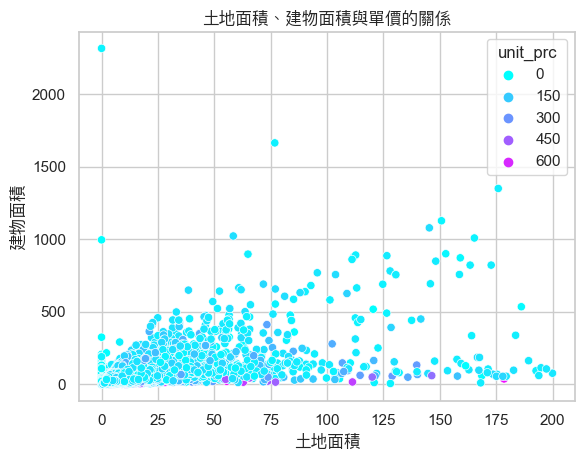

In [861]:
sns.scatterplot(x='land_area', y='build_area', hue = 'unit_prc', data=filtered_data, palette='cool')
plt.title('土地面積、建物面積與單價的關係', size=14, fontproperties=fontset02)
plt.xlabel('土地面積', size=12, fontproperties=fontset02)
plt.ylabel('建物面積', size=12, fontproperties=fontset02)

plt.savefig(path_fig + r'/land_build.png', dpi=300, bbox_inches='tight')

plt.show()

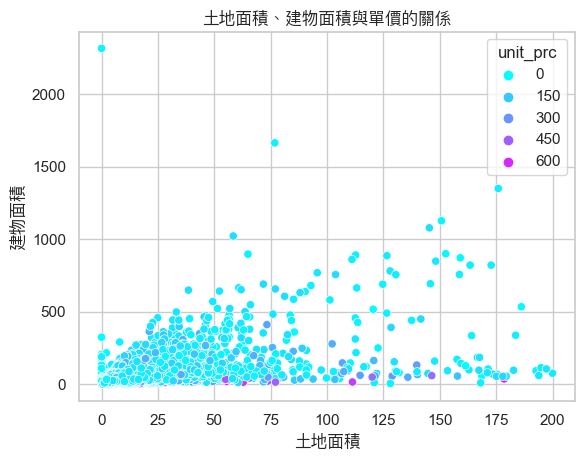

In [862]:
filtered_data6 = data[data['land_area'] <= 200]
sns.scatterplot(x='land_area', y='build_area', hue = 'unit_prc', data=filtered_data6, palette='cool')
plt.title('土地面積、建物面積與單價的關係', size=14, fontproperties=fontset02)
plt.xlabel('土地面積', size=12, fontproperties=fontset02)
plt.ylabel('建物面積', size=12, fontproperties=fontset02)
plt.savefig(path_fig + r'/land_build2.png', dpi=300, bbox_inches='tight')

plt.show()

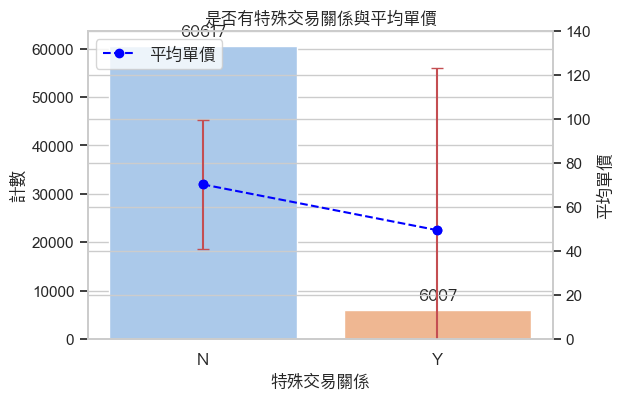

In [128]:
# 特殊交易關係（自己新增的變數）

data['relation'] = np.where(data['rmk'].str.contains('特殊關係')==True, 'Y', 'N')
sns.set_palette('pastel') 
plt.figure(figsize=(6, 4))
ax1 = sns.countplot(x = data["relation"])
ax1.set_xlabel('特殊交易關係', size=12, fontproperties=fontset02)
ax1.set_ylabel('計數', size=12, fontproperties=fontset02)

# avg_price_per_area = data.groupby('relation')['unit_prc'].mean().reset_index()
avg_price_per_area = data.groupby(['relation']).agg(
                                    平均單價=('unit_prc', np.mean),
                                    標準差 =('unit_prc', np.std)).reset_index()  

order = ax1.get_xticklabels()
order = [o.get_text() for o in order]
avg_price_per_area['relation'] = pd.Categorical(
    avg_price_per_area['relation'],
    categories=order,
    ordered=True
)
avg_price_per_area = avg_price_per_area.sort_values('relation')

#加數值
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontproperties=fontset02)

    

ax2 = ax1.twinx()
ax2.set_ylabel('平均單價', size=12, fontproperties=fontset02)
# ax2.set_ylim(0, 100) 
ax2.plot(avg_price_per_area['relation'], avg_price_per_area['平均單價'], 
         color='blue', marker='o', linestyle='dashed', label='平均單價')
ax2.errorbar(avg_price_per_area['relation'], avg_price_per_area['平均單價'], 
             yerr = avg_price_per_area['標準差'], fmt='o', capsize=4,
             mfc='blue', mec='blue', ecolor='r')#, label='1 sd')

for label in ax1.get_xticklabels():
    label.set_fontproperties(fontset02)

ax2.set_ylim(0, 140) 
ax2.legend(prop=fontset02)


plt.title('是否有特殊交易關係與平均單價', fontproperties=fontset02)
plt.savefig(path_fig + r'/relation.png', dpi=300, bbox_inches='tight')

plt.show()


In [864]:
data_cont = data.drop(['ID'], axis=1)
data_cont = data_cont.select_dtypes(exclude = ["object"])

In [865]:
len(data_cont.columns)

17

In [866]:
data_cont.columns = ['經度', '緯度', '土地', '建物', '車位', '土地移轉坪數', '移轉地上樓層', '總樓層', '屋齡',
                    '建物移轉坪數', '房數', '廳數', '衛浴數', '車位總面積', '總價(萬)', '單價', '車位總價']

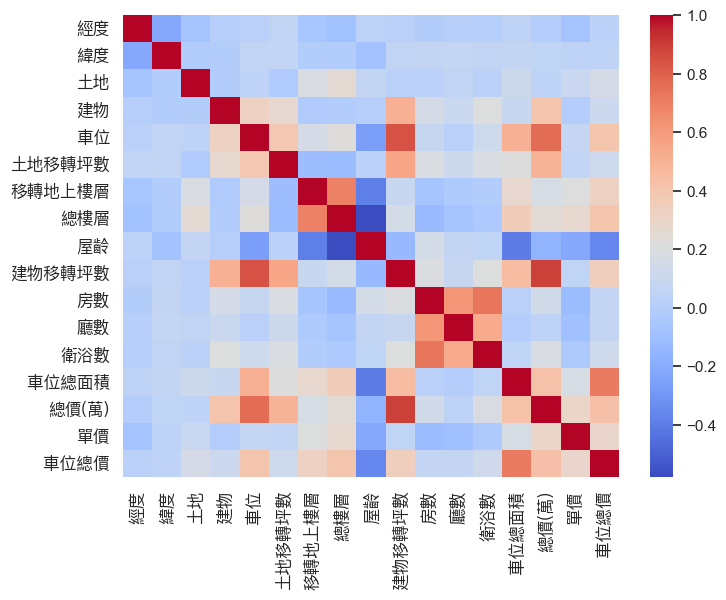

In [867]:
fig= plt.figure(figsize=[8, 6])
corr = data_cont.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')
plt.xticks(fontproperties=fontset02)
plt.yticks(fontproperties=fontset02)
plt.savefig(path_fig + r'/corr.png', dpi=300, bbox_inches='tight')

plt.show()

In [868]:
data_cont.describe().T

,count,mean,std,min,25%,50%,75%,max
經度,59180.0,25.055953,0.035853,24.974580,25.033426,25.052866,25.074671,25.170634
緯度,59180.0,121.543657,0.031913,121.457247,121.519913,121.539381,121.566082,121.624197
土地,66624.0,2.084849,3.815038,0.000000,1.000000,1.000000,2.000000,53.000000
建物,66624.0,1.040721,0.486562,0.000000,1.000000,1.000000,1.000000,62.000000
車位,66624.0,0.498844,1.506969,0.000000,0.000000,0.000000,1.000000,235.000000
土地移轉坪數,66624.0,8.130024,16.733623,0.000000,3.250000,6.390000,9.720000,1206.980000
移轉地上樓層,66624.0,5.944540,4.573955,0.000000,3.000000,5.000000,8.000000,42.000000
總樓層,66624.0,10.543198,6.094606,0.000000,5.000000,10.000000,14.000000,42.000000
屋齡,54867.0,24.309623,16.581708,0.000000,8.700000,25.800000,38.800000,105.400000
建物移轉坪數,66624.0,40.256882,65.670366,0.000000,21.500000,31.990000,47.140000,9423.780000


In [869]:
# 連續型變數之敘述性統計
round(data_cont.iloc[:, :8].describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
經度,59180.0,25.06,0.04,24.97,25.03,25.05,25.07,25.17
緯度,59180.0,121.54,0.03,121.46,121.52,121.54,121.57,121.62
土地,66624.0,2.08,3.82,0.00,1.00,1.00,2.00,53.00
建物,66624.0,1.04,0.49,0.00,1.00,1.00,1.00,62.00
車位,66624.0,0.50,1.51,0.00,0.00,0.00,1.00,235.00
土地移轉坪數,66624.0,8.13,16.73,0.00,3.25,6.39,9.72,1206.98
移轉地上樓層,66624.0,5.94,4.57,0.00,3.00,5.00,8.00,42.00
總樓層,66624.0,10.54,6.09,0.00,5.00,10.00,14.00,42.00


In [870]:
round(data_cont.iloc[:, 8:].describe().T,2)

,count,mean,std,min,25%,50%,75%,max
屋齡,54867.0,24.31,16.58,0.0,8.7,25.80,38.80,105.40
建物移轉坪數,66624.0,40.26,65.67,0.0,21.5,31.99,47.14,9423.78
房數,66624.0,2.34,1.54,0.0,1.0,3.00,3.00,125.00
廳數,66624.0,1.52,0.81,0.0,1.0,2.00,2.00,69.00
衛浴數,66624.0,1.49,1.01,0.0,1.0,1.00,2.00,94.00
車位總面積,65621.0,3.70,8.53,0.0,0.0,0.00,5.48,626.46
總價(萬),66624.0,2708.56,4805.44,0.0,1200.0,1860.00,3025.00,642000.00
單價,66624.0,68.40,36.24,0.0,49.5,63.90,81.60,5303.40
車位總價,66624.0,77.29,191.40,0.0,0.0,0.00,0.00,11780.00


In [871]:
# 更好地將類別變數轉成連續變數的方法
# 距離以外考量重要性
# 距離計算方式

In [872]:
## 地坪指的就是實際持有的土地坪數，是建築用地的總面積。通常透天厝都會有獨立持有的土地坪數，而且通常不小，對於總價有決定性的影響
## 建坪是建築物中實際建築面積加總坪數，陽台、公設等面積都包含在內，即所有的樓板面積，加上所持有的公設坪數。

# 如果這個變數的某些類別對價格的影響非常明顯，而且這種影響與其他類別明顯不同，那麼您可以考慮為這些不同的類別建立不同的模型
# 一筆交易可能涉及多個不動產單位，並且這些單位可能有不同的價格。當每個單位（如每棟建物）有其獨立的交易價格時，需要為每個單位單獨填寫和提交一份申報書。

In [873]:
# 不知怎麼處理的變數：
# 1. land build berth (交易的土地筆數, 交易的建物筆數, 交易的車位元筆數) 看不是很懂...
# 3. tran_floor tran_up_ll tran_single: 這三個變數該如何處理勒？（目前想的是tran_up_ll保留最高樓層 tran_single改成數值總共有幾層）

# 5. tot_floor: 該筆不動產總樓層數 (不是賣掉幾層 是該棟有幾層) 這個變數有需要ㄇ

# 6. top_floor	該筆不動產移轉樓層是否為頂樓 這個變數有需要ㄇ

# 7. build_dd 建造日期 已經有屋齡 這個變數有需要ㄇ

# 8. room hall health (要組合起來當作類別變數看嗎? 還是個別當連續變數看？)
# 9. compart 不動產有無隔間 (這個變數有需要嗎 只要room hall health有值 就會是Y)

# 10. berth_tp車位類別   (只考慮)
# 11. berth_area 車位總面積(坪)
# 12. berth_prc車位總價

# 13. ann_date 公告日


# 14. y要放 tot_prc 還是 unit_prc ??